In [ ]:
## This notebook offers a simple example of how to construct a LangGraph.

## Example - 1

In [32]:
from langgraph.graph import START, StateGraph
from langgraph.graph import StateGraph,  END
from IPython.display import Image, display

def add(state, config):
    print(state)
    return {"x": state["x"] + 1}

def multiply(state, config):
    print(state)
    return {"y": state["x"]*2}

builder = StateGraph(dict)

builder.add_node("add", add)
builder.add_node("multiply", multiply)

builder.set_entry_point("add")

builder.add_edge("add", "multiply")
builder.add_edge("multiply", END)

graph = builder.compile()

initial_state = {"x":1}
graph.invoke(initial_state)


{'x': 1}
{'x': 2}


{'y': 4}

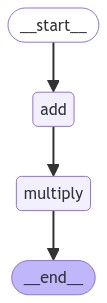

In [33]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [40]:
builder.edges

{('__start__', 'a'), ('a', 'b'), ('b', '__end__')}

In [41]:
builder.nodes

{'a': NodeSpec(runnable=a(recurse=True), metadata=None),
 'b': NodeSpec(runnable=b(recurse=True), metadata=None)}

In [42]:
builder.schema

__main__.State

## Example - 2

In [34]:
import operator
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph,  END
from IPython.display import Image, display

class State(TypedDict):
    messages: Annotated[List[str], operator.add]

def add(state, config):
    print(state)
    msg = state['messages'][-1]
    response = {"x": msg["x"] + 1}
    return {"messages": [response]}

def multiply(state, config):
    print(state)
    msg = state['messages'][-1]
    response = {"x": msg["x"]*2}
    return {"messages": [response]}

builder = StateGraph(State)

builder.add_node("my_node1", add)
builder.add_node("my_node2", multiply)
builder.set_entry_point("my_node1")

builder.add_edge("my_node1", "my_node2")
builder.add_edge("my_node2", END)

graph = builder.compile()

input_state = {'messages': [{"x": 1}]}

graph.invoke(input_state)


{'messages': [{'x': 1}]}
{'messages': [{'x': 1}, {'x': 2}]}


{'messages': [{'x': 1}, {'x': 2}, {'x': 4}]}

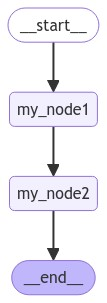

In [35]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Example - 3

In [36]:
import operator
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph,  END
from IPython.display import Image, display

# Define the State schema
class State(TypedDict):
    messages: Annotated[List[str], operator.add]

# Create a StateGraph instance
builder = StateGraph(State)

# Add a node that returns a value
class ReturnNodeValue:
    def __init__(self, value: str):
        self.value = value

    def __call__(self, state: State) -> dict:
        return {"messages": [self.value]}

# Add nodes to the graph
builder.add_node("a", ReturnNodeValue("Hello"))
builder.add_node("b", ReturnNodeValue("World"))
builder.set_entry_point("a")

builder.add_edge("a", "b")
builder.add_edge("b", END)

# Compile the graph
graph = builder.compile()

# Invoke the graph with an initial state
initial_state = {"messages": []}
result = graph.invoke(initial_state)

# Print the final result
print(result)

{'messages': ['Hello', 'World']}


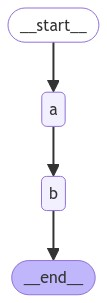

In [37]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [38]:
first_node=ReturnNodeValue("Hello")
first_node.__call__({'message':[]})


{'messages': ['Hello']}

In [39]:
second=ReturnNodeValue("world")
second.__call__({'messages': ['Hello']})

{'messages': ['world']}

## Example - 4

In [43]:
import os
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
import operator
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph,  END
from IPython.display import Image, display

OPENAI_API_KEY="sk-xxx" # provide your active openai api key and use other gpt models if you don't have access to gpt-4o model
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

llm = ChatOpenAI(model='gpt-4o')

# Define the State schema
class State(TypedDict):
    messages: Annotated[List[str], operator.add]

# Create a StateGraph instance
builder = StateGraph(State)

def call_model(state):
    #print(state)
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

def convert_human(state):
    #print(state)
    messages = state['messages']
    messages = messages[-1] # taking last message
    content = messages.content
    response = HumanMessage(content=content)
    return {"messages": [response]}

# Add nodes to the graph
builder.add_node("model_call", call_model)
builder.add_node("human_message", convert_human)
builder.set_entry_point("model_call")

builder.add_edge("model_call", "human_message")
builder.add_edge("human_message", END)

# Compile the graph
graph = builder.compile()

query="What is the Capital City of Nepal?"
input_message = {"messages": [HumanMessage(content=query)]}

result = graph.invoke(input_message)

print(result)



{'messages': [HumanMessage(content='What is the Capital City of Nepal?'), AIMessage(content='The capital city of Nepal is Kathmandu. It is the largest city in the country and serves as the political, cultural, and economic center of Nepal.', response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 15, 'total_tokens': 45}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_18cc0f1fa0', 'finish_reason': 'stop', 'logprobs': None}, id='run-13171dff-c8db-4dc2-b699-d9eb5b7892d8-0'), HumanMessage(content='The capital city of Nepal is Kathmandu. It is the largest city in the country and serves as the political, cultural, and economic center of Nepal.')]}


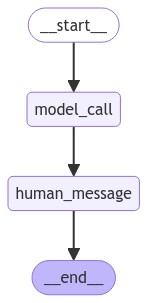

In [44]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
